# Analysis of datasets from Grand Mesa - 11 Feb 2020

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import xarray as xr
import rioxarray
import scipy.io as sio
import datetime
import pandas as pd
from scipy.signal import argrelextrema, argrelmax, argrelmin
from shapely.geometry import Polygon
import geojson
import mat73
import ir_utils
import aster_utils
import glob
import geopandas as gpd

In [2]:
# Import some packages for working with the SnowEx SQL database
from snowexsql.db import get_db # Import the connection function from the snowexsql library
from  snowexsql.data import SiteData # Import the table classes from our data module which is where our ORM classes are defined 
from datetime import date # Import some tools to build dates 
from snowexsql.conversions import query_to_geopandas # Import a useful function for plotting and saving queries! See https://snowexsql.readthedocs.io/en/latest/snowexsql.html#module-snowexsql.conversions

Read .mat files in xarray datasets

In [3]:
files = [r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked.mat',
         r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_EO_PLANE_2020Feb11_mosaicked.mat',
         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb10_mosaicked.mat',
         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked.mat',
         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb12_mosaicked.mat'
        ]

ds_eo = ir_utils.eo_mat2dataset(files[1])

ds_ir = ir_utils.ir_mat2dataset(files[0])



### Get locations of ground points

Snowpit 2S10

In [4]:
# snowpit from the snowexsql database
# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [5]:
# Form the query to receive site_id='2S10' from the sites table
qry = session.query(SiteData).filter_by(site_id='2S10')

# Convert the record received into a geopandas dataframe
snow_pit_df = query_to_geopandas(qry, engine).to_crs(ds_ir.rio.crs)

# Preview the resulting geopandas dataframe
snow_pit_df

,site_name,date,time_created,time_updated,id,doi,date_accessed,latitude,longitude,northing,...,weather_description,precip,sky_cover,wind,ground_condition,ground_roughness,ground_vegetation,vegetation_height,tree_canopy,site_notes
0,Grand Mesa,2020-02-05,2022-06-30 22:28:52.494279+00:00,None,130,https://doi.org/10.5067/DUD2VZEVBJ7S,None,39.019474,-108.192316,4322689.0,...,"Sunny and cold, some blowing snow",None,Few (< 1/4 of sky),Moderate,Frozen,Rough,"Grass, Shrub","20, 30",No Trees,None


Mesa West met station

In [6]:
# Met stations that aren't in the snowexsql database
#convert met site data to a geodataframe for plotting with DEM basemap
met_sites = pd.read_csv(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\SnowEx\SnowEx Met Data\SnowEx2020_met_data\MesaMetSites.csv')
#met_sites['geometry'] = [Point(row['longitude'], row['latitude']) for row in met_sites]
met_sites_gdf = gpd.GeoDataFrame(met_sites, geometry=gpd.points_from_xy(met_sites.longitude, met_sites.latitude))
met_sites_gdf.crs = 4236

In [7]:
met_sites_gdf

,siteName,siteShortName,latitude,longitude,elev_m,start,end,geometry
0,LSOS,LSOS,39.05225,-108.09792,2974,10/9/16 18:20,5/17/17 15:40,POINT (-108.09792 39.05225)
1,Mesa East,ME,39.10358,-107.88383,2750,10/10/16 16:30,7/28/20 11:30,POINT (-107.88383 39.10358)
2,Mesa West,MW,39.03388,-108.21399,3033,10/9/16 21:00,7/8/20 17:00,POINT (-108.21399 39.03388)
3,Mesa Middle,MM,39.03954,-107.94174,3176,10/10/16 19:00,6/9/20 20:10,POINT (-107.94174 39.03954)
4,Skyway,GMSP,39.05084,-108.06144,3234,10/10/16 0:50,7/19/20 5:50,POINT (-108.06144 39.05084)


In [8]:
# Select the Mesa West site, and reproject to UTM
mesa_west_df = met_sites_gdf[met_sites_gdf.siteName == 'Mesa West'].to_crs(ds_ir.rio.crs)

# correct the point
mesa_west_df['geometry'] = gpd.points_from_xy([221797.741], [4325448.904], crs=ds_ir.rio.crs)

# Preview the resulting geopandas dataframe
mesa_west_df

,siteName,siteShortName,latitude,longitude,elev_m,start,end,geometry
2,Mesa West,MW,39.03388,-108.21399,3033,10/9/16 21:00,7/8/20 17:00,POINT (221797.741 4325448.904)


---

Define some functions I'll use here

In [9]:
def get_hist_trough(data):
    
    '''Function for finding the local minima (troughs) between peaks in a histogram.'''
    
    # first, find peaks
    x_peaks, y_peaks, _, _ = get_hist_peaks(data)
    
    # only look at data between the two peaks
    data = data[(data > x_peaks[0]) & (data < x_peaks[1])]
    
    # data histogram
    n_histogram, _ = np.histogram(data, bins=100, density=True)
    
    # make our own data bins of length n
    x = np.linspace(np.min(data), np.max(data), num=len(n_histogram))
    
    # find minimum n_troughs
    if len(np.sort(n_histogram[argrelmin(n_histogram, order=1)]))>1:
        trough_y_values = np.sort(n_histogram[argrelmin(n_histogram, order=1)])[0]
    else:
        trough_y_values = np.sort(n_histogram[argrelmin(n_histogram, order=1)])
    # find corresponding x values to the n_troughs
    trough_x_values = x[np.where(np.isin(n_histogram,trough_y_values))]
    
    # demo plot
    #plt.bar(x, n_histogram)
    #plt.plot(trough_x_values, trough_y_values,'or')
    
    x_hist = x
    y_hist = n_histogram
    
    return trough_x_values, trough_y_values, x_hist, y_hist

In [10]:
def get_hist_peaks(data,n_peaks=2):
    
    '''Function for finding the local maxima (peaks) in a histogram.'''
    
    # remove nans from data
    data = data[~np.isnan(data)]
    
    # data histogram
    n_histogram, _ = np.histogram(data, bins=100, density=True)
    
    # make our own data bins of length n
    x = np.linspace(np.min(data), np.max(data), num=len(n_histogram))
    
    # find maximum n_peaks
    peak_y_values = np.sort(n_histogram[argrelmax(n_histogram, order=2)])[-n_peaks:][::-1]
    # find corresponding x values to the n_peaks
    peak_x_values = x[np.where(np.isin(n_histogram,peak_y_values))]
    
    # demo plot
    #plt.bar(x, n_histogram)
    #plt.plot(peak_x_values, peak_y_values,'or')
    
    x_hist = x
    y_hist = n_histogram
    
    return peak_x_values, peak_y_values, x_hist, y_hist

---
## Load merged and cleaned data

In [11]:
df_merged = pd.read_csv(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\Mountain GOES Paper\Paper 2 - satellite vs ground\GOES-16_ABI_data\merged_datasets.csv')
df_merged.set_index(pd.to_datetime(df_merged.datetime), inplace=True)

---
---

# Plotting

Compare ground point measurement to airborne IR aggregated across different sized areas (from one 5 m pixel up to 1 km2)

C:\Users\steve\AppData\Local\Temp\ipykernel_8072\3247993398.py:80: RuntimeWarning: Mean of empty slice
  mean_difference = np.nanmean(np.nanmean(point_temps, axis=(1,2)) - np.array(gm1_2s10_IR_45deg_C))
C:\Users\steve\AppData\Local\Temp\ipykernel_8072\3247993398.py:81: RuntimeWarning: Mean of empty slice
  ax.plot(gm1_2s10_IR_45deg_C, np.nanmean(point_temps, axis=(1,2)), '.b')


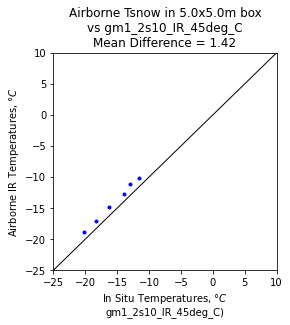

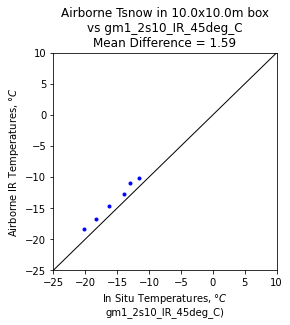

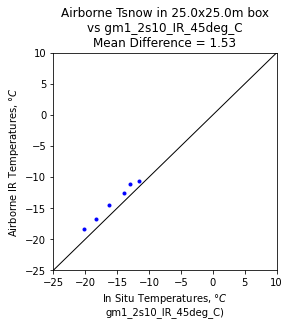

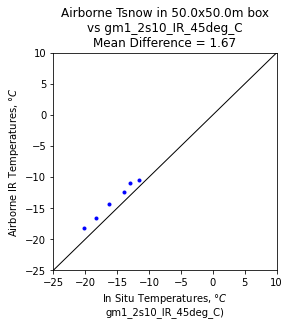

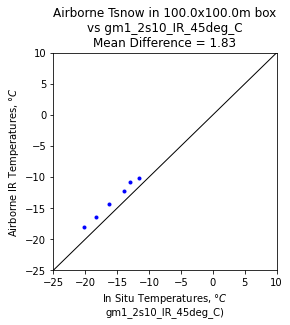

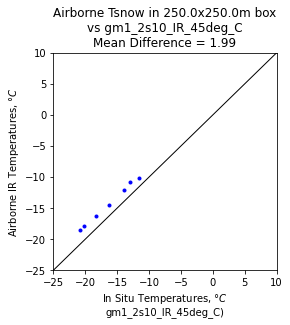

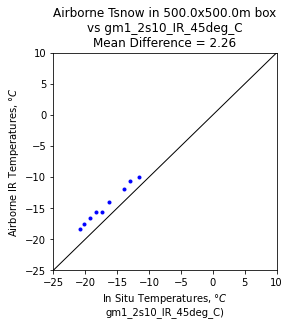

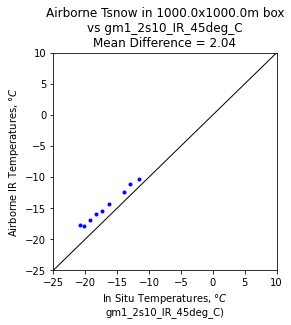

In [12]:
target = 'snow pit'
#target = 'mesa west'
ds = ds_ir

# Select a time window from the timeseries data around each airborne or satellite observation
plus_minus_minutes = 10 # e.g. +/- 5 minutes for a 10 minute time window

mean_AirTC_10ft_Avg_C = []
mean_AirTC_20ft_Avg_C = []
mean_IRtarget_nadir1_C_Avg = []
mean_IRtarget_30degN_C_Avg = []
gm1_2s10_IR_45deg_C = []

for i, t in enumerate(ds.time.values):
    window_start_time = pd.to_datetime(t) - datetime.timedelta(minutes=plus_minus_minutes)
    window_end_time = pd.to_datetime(t) + datetime.timedelta(minutes=plus_minus_minutes)
    #df_sliced = df[(df.index>window_start_time) & (df.index<window_end_time)]
    #gm1_sliced = gm1[(gm1.index>window_start_time) & (gm1.index<window_end_time)]
    df_merged_sliced = df_merged[(df_merged.index>window_start_time) & (df_merged.index<window_end_time)]

    #mean_AirTC_10ft_Avg_C.append(df_sliced.AirTC_10ft_Avg_C.mean())
    #mean_AirTC_20ft_Avg_C.append(df_sliced.AirTC_20ft_Avg_C.mean())
    mean_AirTC_20ft_Avg_C.append(df_merged_sliced.AirTC_20ft_Avg.mean()-273.15)
    #mean_IRtarget_nadir1_C_Avg.append(df_sliced.IRtarget_nadir1_C_Avg.mean())
    #mean_IRtarget_30degN_C_Avg.append(df_sliced.IRtarget_30degN_C_Avg.mean())
    #gm1_2s10_IR_45deg_C.append(gm1_sliced.rad_avg.mean())
    gm1_2s10_IR_45deg_C.append(df_merged_sliced.rad_avg.mean()-273.15)
    
    
#############

mean_differences = []
point_temps_list = []


# set the spatial extent for looking at the exact "point"
#n_pixels_list = [1, 2, 5, 10, 25, 50, 100, 150, 200, 250]
point_window_list = [5/2, 10/2, 25/2, 50/2, 100/2, 250/2, 500/2, 1000/2]

for point_window in point_window_list:
    #point_window = n_pixels*2.5 # must be >= 2.5 meters in order to capture at least one pixel
    x = point_window
    if target == 'mesa west':
        # mesa west tree stand area
        utm_xmin, utm_xmax = mesa_west_df.geometry.x.values[0]-x, mesa_west_df.geometry.x.values[0]+x #221800-x, 221800+x
        utm_ymin, utm_ymax = mesa_west_df.geometry.y.values[0]-x, mesa_west_df.geometry.y.values[0]+x #4325500-x, 4325500+x
    if target == 'snow pit':
        # snow pit 2s10 area
        utm_xmin, utm_xmax = snow_pit_df.geometry.x.values[0]-x, snow_pit_df.geometry.x.values[0]+x #221800-x, 221800+x
        utm_ymin, utm_ymax = snow_pit_df.geometry.y.values[0]-x, snow_pit_df.geometry.y.values[0]+x


    point_temps = []
    for time_index, time_step in enumerate(ds.time):
            # get temperature right at our ground point
            if target == 'mesa west':
                # mesa west
                point_temp_C = ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values
            if target == 'snow pit':
                # snow pit
                point_temp_C = ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values

            point_temps.append(point_temp_C)
            
    point_temps = np.array(point_temps)
    point_temps_removed_nans = point_temps[~np.isnan(point_temps)]
    point_temps_list.append(point_temps)
    point_temps_half_range = np.max(point_temps_removed_nans) - np.min(point_temps_removed_nans)

    fig, ax = plt.subplots(figsize=(4,4))
    
    if target == 'mesa west':
        mean_difference = np.nanmean(np.nanmean(point_temps, axis=(1,2)) - np.array(mean_AirTC_20ft_Avg_C))
        ax.plot(mean_AirTC_20ft_Avg_C, np.nanmean(point_temps, axis=(1,2)), '.b')
        ax.set_xlabel('In Situ Temperatures, $\degree C$\nAirTC_20ft_Avg_C)')
        ax.set_ylabel('Airborne IR Temperatures, $\degree C$')
        ax.set_title(f'Airborne Tsnow in {point_window*2}x{point_window*2}m box\nvs AirTC_20ft_Avg_C\nMean Difference = {np.round(mean_difference,2)}')

    if target == 'snow pit':
        mean_difference = np.nanmean(np.nanmean(point_temps, axis=(1,2)) - np.array(gm1_2s10_IR_45deg_C))
        ax.plot(gm1_2s10_IR_45deg_C, np.nanmean(point_temps, axis=(1,2)), '.b')
        ax.set_xlabel('In Situ Temperatures, $\degree C$\ngm1_2s10_IR_45deg_C)')
        ax.set_ylabel('Airborne IR Temperatures, $\degree C$')
        ax.set_title(f'Airborne Tsnow in {point_window*2}x{point_window*2}m box\nvs gm1_2s10_IR_45deg_C\nMean Difference = {np.round(mean_difference,2)}')

    
    ax.plot([-25,25],[-25,25],linestyle='-', linewidth=1,color='k')
    ax.set_ylim((-25,10))
    ax.set_xlim((-25,10))
    
    mean_differences.append(mean_difference)


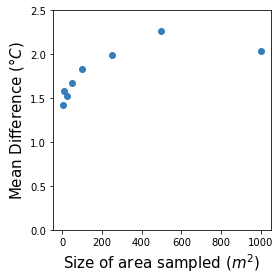

In [13]:
# plot mean differences        
fig, ax = plt.subplots(figsize=(4,4),tight_layout=True)
ax.plot(np.array(point_window_list)*2, mean_differences, 'o', c='#377EB8')
ax.set_ylabel('Mean Difference ($\degree C$)', fontsize=15)
ax.set_xlabel('Size of area sampled ($m^2$)', fontsize=15)
ax.set_ylim(0,2.5)
plt.savefig('sample_area_test_feb11.svg')

Plot histograms

Text(0.5, 0, 'Temperature [$\\degree C$]')

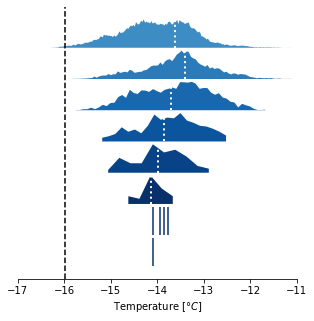

In [14]:
N = len(point_temps_list)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(1,0.5,N)))

fig, ax_hist = plt.subplots(figsize=(5,5))
for n, data in enumerate(point_temps_list):
    data = np.nanmean(data,axis=0).ravel()
    # plot histograms
    y_histogram, x_histogram = np.histogram(data, bins=int(np.sqrt(len(data))), density=True)
    x_histogram = x_histogram[:-1]
    if len(y_histogram) < 5:
        ax_hist.vlines(data, ymin=(n*1.1)+np.zeros_like(data),  ymax=(n*1.1)+np.ones_like(data))
    else:
        ax_hist.fill_between(x_histogram, y1=(n*1.1), y2=(n*1.1)+(y_histogram/(np.max(y_histogram))),zorder=-999)
        max_y = np.max((n*1.1)+(y_histogram/(np.max(y_histogram))))
        ax_hist.vlines(np.mean(x_histogram), ymin=(n*1.1), ymax=max_y, color='w', linestyle=':', lw=2, zorder=999) 
          
ax_hist.axvline(np.array(gm1_2s10_IR_45deg_C).mean(), 0, max_y, c='k', linestyle='--')  
ax_hist.set_xlim(-17, -11)
#ax_hist.set_ylim(0,1)
ax_hist.set_ylabel('')
ax_hist.set(yticklabels=[])
ax_hist.get_yaxis().set_ticks([])
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['bottom'].set_visible(True)
ax_hist.spines['left'].set_visible(False)
ax_hist.set_xlabel('Temperature [$\degree C$]')

---

Tsnow_airborneIR_peak = [-17.59488595 -15.99947351 -14.41402799 -12.78164062 -11.15677468
 -10.20212969]
Tsnow_airborneIR_median = [-17.881529 -15.934866 -14.333548 -12.475851 -11.072775 -10.322744]
Tsnow_airborneIR_mean = [-17.934055 -15.904057 -14.316925 -12.469591 -11.088943 -10.331519]
Tsnow_airborneIR_min = [-22.28118  -19.321066 -17.749868 -16.70371  -13.860754 -13.836187]
Tsnow_airborneIR_max = [-13.359198  -12.470282   -9.886816   -6.747687   -5.9874024  -4.8418946]
Tsnow_airborneIR_std = [1.0294831  0.902477   0.91293883 0.8590098  0.7374493  0.76596993]


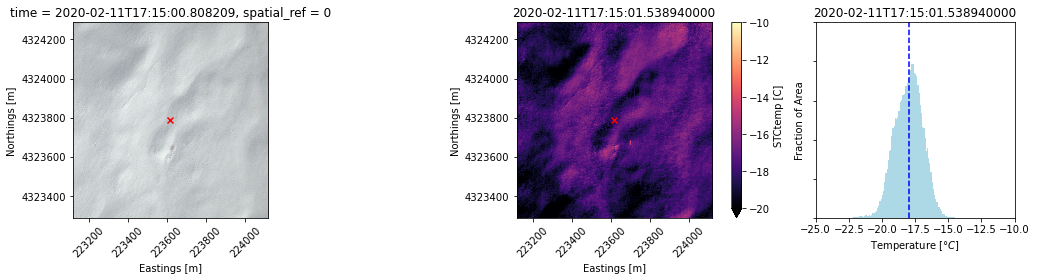

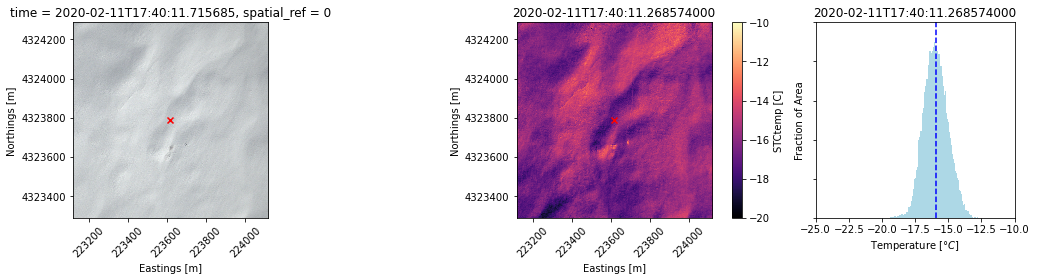

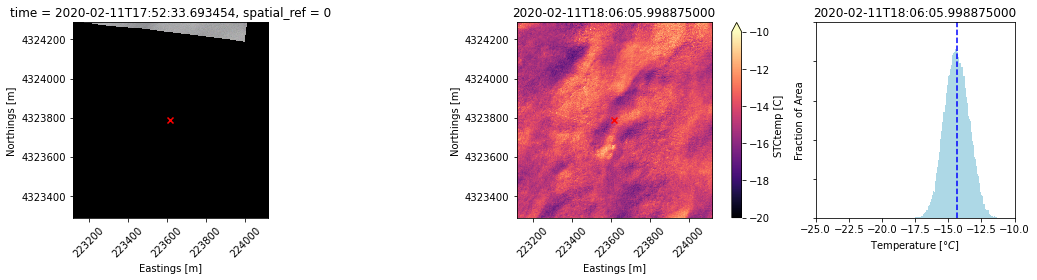

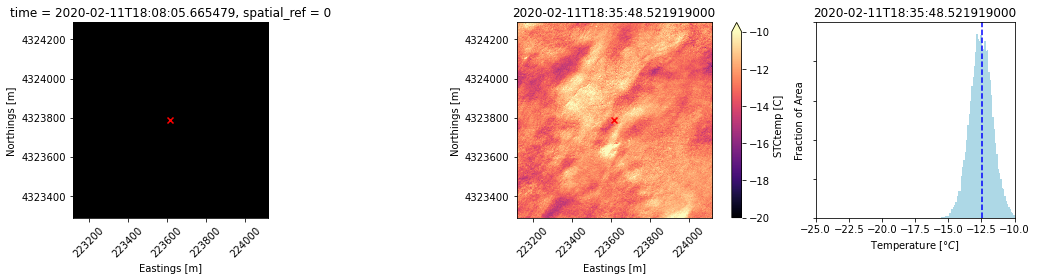

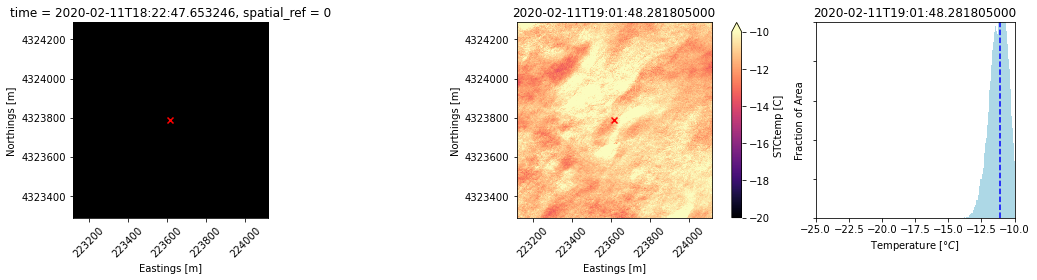

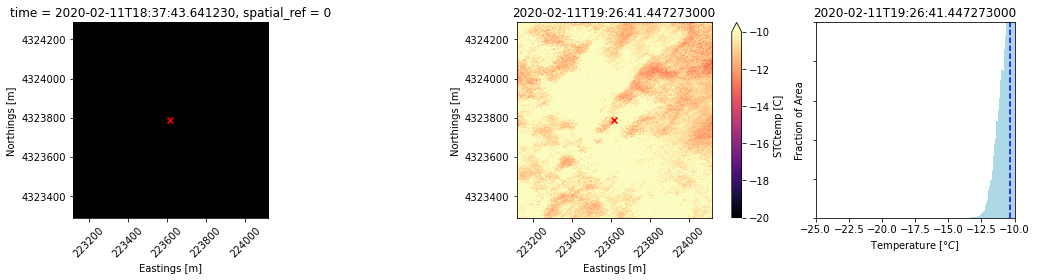

In [15]:
target = 'snow pit'
# Set the spatial extent for the area to look at
x=500 # meters, window will be a square 2x along each side

if target == 'mesa west':
    # mesa west tree stand area
    utm_xmin, utm_xmax = mesa_west_df.geometry.x.values[0]-x, mesa_west_df.geometry.x.values[0]+x #221800-x, 221800+x
    utm_ymin, utm_ymax = mesa_west_df.geometry.y.values[0]-x, mesa_west_df.geometry.y.values[0]+x #4325500-x, 4325500+x
if target == 'snow pit':
    # snow pit 2s10 area
    utm_xmin, utm_xmax = snow_pit_df.geometry.x.values[0]-x, snow_pit_df.geometry.x.values[0]+x #221800-x, 221800+x
    utm_ymin, utm_ymax = snow_pit_df.geometry.y.values[0]-x, snow_pit_df.geometry.y.values[0]+x
 
    
times = []
Tsnow_airborneIR_peak = []
Ttree_airborneIR_peak = []
Tsnow_airborneIR_median = []
Ttree_airborneIR_median = []
Tsnow_airborneIR_mean = []
Ttree_airborneIR_mean = []
Tsnow_airborneIR_min = []
Ttree_airborneIR_min = []
Tsnow_airborneIR_max = []
Ttree_airborneIR_max = []
Tsnow_airborneIR_std = []
Ttree_airborneIR_std = []
Tsnow_differences = []

for time_index, time_step in enumerate(ds.time):
    nan_pixels = np.sum(np.isnan(ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values))
    if nan_pixels < 10000:
        fig, [ax_vis, ax_img, ax_hist] = plt.subplots(nrows=1,ncols=3,figsize=(15,4), tight_layout=True,
                                              gridspec_kw={'width_ratios': [2,2, 1]})
        
      
        # plot visible image
        ds_eo.SRGB.isel(time=time_index).sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax)).plot.imshow(ax=ax_vis)
        ax_vis.set_aspect('equal', 'box')
        ax_vis.set_ylabel('Northings [m]')
        ax_vis.set_xlabel('Eastings [m]')
        ax_vis.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax_vis.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax_vis.tick_params('x', labelrotation=45)
        
        # plot ir image
        ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).plot.imshow(cmap='magma', vmin=-20, vmax=-10, ax=ax_img)
        ax_img.set_aspect('equal', 'box')
        ax_img.set_ylabel('Northings [m]')
        ax_img.set_xlabel('Eastings [m]')
        ax_img.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax_img.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax_img.tick_params('x', labelrotation=45)
        
        ## plot ground points
        for this_ax in [ax_vis, ax_img]:
            if target == 'mesa west':
                mesa_west_df.plot(ax=this_ax, color='r', marker='x', zorder=999)
            if target == 'snow pit':
                snow_pit_df.plot(ax=this_ax, color='r', marker='x', zorder=999)
        
        # plot histograms
        data = ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values
        x_peaks, y_peaks, x_hist, y_hist = get_hist_peaks(data, n_peaks=1)
        #x_trough, _, _, _ = get_hist_trough(data)
        if len(x_peaks) == 1: # add some placeholder data if we only are looking at n_peaks=1
            x_peaks = np.append(x_peaks, -9999)
            y_peaks = np.append(y_peaks, -9999)
            x_trough = [9999]
        x_hist_snow = x_hist[x_hist < x_trough[0]]
        y_hist_snow = y_hist[x_hist < x_trough[0]]
        x_hist_tree = x_hist[x_hist >= x_trough[0]]
        y_hist_tree = y_hist[x_hist >= x_trough[0]]
        # alternate histogram
        y_histogram, x_histogram = np.histogram(data, bins=100, density=True)
        ax_hist.bar(x_histogram[:-1], y_histogram, width=0.1, color='lightblue')
        #ax_hist.bar(x_hist_snow, y_hist_snow, color='lightblue')
        #ax_hist.axvline(np.median(data[data < x_trough[0]]),color='b',linestyle='--')
        ax_hist.axvline(np.mean(data[data < x_trough[0]]),color='b',linestyle='--')
        if target == 'mesa west':
            ax_hist.bar(x_hist_tree, y_hist_tree, color='lightgreen')
            ax_hist.axvline(np.median(data[data >= x_trough[0]]),color='g',linestyle='--')
            ax_hist.axvline(np.mean(data[data >= x_trough[0]]),color='g',linestyle=':')
        #ax_hist.plot(x_peaks[0], y_peaks[0],'ob')
        ax_hist.plot(x_peaks[1], y_peaks[1],'^g')
        ax_hist.set_xlim(-25, -10)
        ax_hist.set_ylim(0,0.5)
        ax_hist.set_ylabel('Fraction of Area')
        ax_hist.set(yticklabels=[])
        ax_hist.set_xlabel('Temperature [$\degree C$]')
        ax_img.set_title(time_step.values)
        ax_hist.set_title(time_step.values)
        # append values to lists
        times.append(time_step.values)
        Tsnow_airborneIR_peak.append(x_peaks[0])
        Tsnow_airborneIR_median.append(np.median(data[data < x_trough[0]]))
        Tsnow_airborneIR_mean.append(np.mean(data[data < x_trough[0]]))
        Tsnow_airborneIR_min.append(np.min(data[data < x_trough[0]]))
        Tsnow_airborneIR_max.append(np.max(data[data < x_trough[0]]))
        Tsnow_airborneIR_std.append(np.std(data[data < x_trough[0]])) 
        if target == 'mesa west':
            Ttree_airborneIR_peak.append(x_peaks[1])
            Ttree_airborneIR_median.append(np.median(data[data >= x_trough[0]]))
            Ttree_airborneIR_mean.append(np.mean(data[data >= x_trough[0]]))
            Ttree_airborneIR_min.append(np.min(data[data >= x_trough[0]]))
            Ttree_airborneIR_max.append(np.max(data[data >= x_trough[0]]))
            Ttree_airborneIR_std.append(np.std(data[data >= x_trough[0]]))
        
times = np.array(times)
Tsnow_airborneIR_peak = np.array(Tsnow_airborneIR_peak)
Tsnow_airborneIR_median = np.array(Tsnow_airborneIR_median)
Tsnow_airborneIR_mean = np.array(Tsnow_airborneIR_mean)
Tsnow_airborneIR_min = np.array(Tsnow_airborneIR_min)
Tsnow_airborneIR_max = np.array(Tsnow_airborneIR_max)
Tsnow_airborneIR_std = np.array(Tsnow_airborneIR_std)
print(f'Tsnow_airborneIR_peak = {Tsnow_airborneIR_peak}')
print(f'Tsnow_airborneIR_median = {Tsnow_airborneIR_median}')
print(f'Tsnow_airborneIR_mean = {Tsnow_airborneIR_mean}')
print(f'Tsnow_airborneIR_min = {Tsnow_airborneIR_min}')
print(f'Tsnow_airborneIR_max = {Tsnow_airborneIR_max}')
print(f'Tsnow_airborneIR_std = {Tsnow_airborneIR_std }')
if target == 'mesa west':
    Ttree_airborneIR_peak = np.array(Ttree_airborneIR_peak)
    Ttree_airborneIR_median = np.array(Ttree_airborneIR_median)
    Ttree_airborneIR_mean = np.array(Ttree_airborneIR_mean)
    Ttree_airborneIR_min = np.array(Ttree_airborneIR_min)
    Ttree_airborneIR_max = np.array(Ttree_airborneIR_max)
    Ttree_airborneIR_std = np.array(Ttree_airborneIR_std)
    print(f'Ttree_airborneIR_peak = {Ttree_airborneIR_peak}')
    print(f'Ttree_airborneIR_median = {Ttree_airborneIR_median}')
    print(f'Ttree_airborneIR_mean = {Ttree_airborneIR_mean}')
    print(f'Ttree_airborneIR_min = {Ttree_airborneIR_min}')
    print(f'Ttree_airborneIR_max = {Ttree_airborneIR_max}')
    print(f'Ttree_airborneIR_std = {Ttree_airborneIR_std }')


---

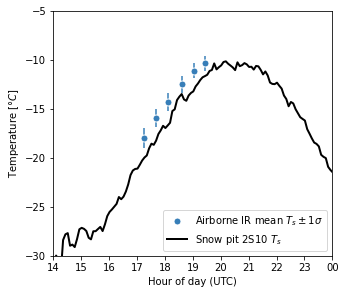

In [16]:
if target == 'mesa west':

    fig, ax =plt.subplots(1,1,figsize=(4,4))
    
    #ax.plot(times,Ttree_airborneIR_peak+273.15,'^g', label='Airborne IR Ttree (mode)')
    #ax.plot(times,Ttree_airborneIR_median+273.15,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
    ax.plot(times,Ttree_airborneIR_mean+273.15,'^g', markerfacecolor='k', label='Airborne IR Ttree (mean)')
    
    ax.errorbar(x=times,y=Ttree_airborneIR_mean+273.15, yerr=Ttree_airborneIR_std, color='g', linestyle='none', label='+/- 1 $/sigma$')
    
    #gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=2, c='k', label='2S10_IR_C', zorder=99)
    
    #df.AirTC_10ft_Avg_C.plot(ax=ax, label='AirTC_10ft_Avg_C',linestyle='--')
    (df_merged.AirTC_20ft_Avg).plot(ax=ax, label='AirTC_20ft_Avg_C',linestyle='--', color='k')
    #df.IRtarget_nadir1_C_Avg.plot(ax=ax, label='IRtarget_nadir1_C_Avg')
    #df.IRtarget_nadir2_C_Avg.plot(ax=ax, label='IRtarget_nadir2_C_Avg')
    #df.IRtarget_30degN_C_Avg.plot(ax=ax, label='IRtarget_30degN_C_Avg')
    #df.TsnowTrue.plot(ax=ax, c='tab:blue', label='West Met station Tsnow')
    #df.TtreeTrue.plot(ax=ax, c='tab:green', label='West Met station Tair')
    #df.TsnowEst.plot(marker='.',ax=ax)
    #df.TtreeEst.plot(marker='.',ax=ax)
    
    ax.set_xlim(np.datetime64('2020-02-11T13'),np.datetime64('2020-02-12'))
    ax.set_ylim(250,270)
    ax.set_ylabel('Temperature, K')
    ax.set_xlabel('Time')
    
    plt.legend(loc='lower right')
    
    #ax2 = ax.twinx()
    #df.Solar.plot(ax=ax2)
    
if target == 'snow pit':
    fig, ax =plt.subplots(1,1,figsize=(5,5))

    #ax.plot(times,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
    #ax.plot(times,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
    ax.plot(times,Tsnow_airborneIR_mean,'o', markeredgecolor='w', markerfacecolor='#377eb8', markersize=7, label='Airborne IR mean $T_s \pm 1 \sigma$', zorder=1)
    
    ax.errorbar(x=times,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='#377eb8', linestyle='none', label=None, zorder=0)
    
    #gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=2, c='k', label='2S10_IR_C', zorder=99)
    (df_merged.rad_avg-273.15).plot(ax=ax, linestyle='-', linewidth=2, c='k', label='Snow pit 2S10 $T_s$', zorder=-1)
    
    ax.set_xlim(np.datetime64('2020-02-11T14'),np.datetime64('2020-02-12'))
    ax.set_ylim(-30,-5)
    ax.set_ylabel('Temperature [$\degree C$]')
    ax.set_xlabel('Hour of day (UTC)')
    
    # Text in the x-axis will be displayed in 'YYYY-mm' format.
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    # Rotates and right-aligns the x labels so they don't crowd each other.
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=0, horizontalalignment='center')
    
    
    plt.legend(loc='lower right')

plt.savefig('fig6c.svg')

Mean Difference between Airborne Tsnow and gm1_2s10_IR_45deg_C:
1.8297731526692853
[2.23869238 2.35019116 2.00181885 1.3706394  1.83431567 1.18298145]


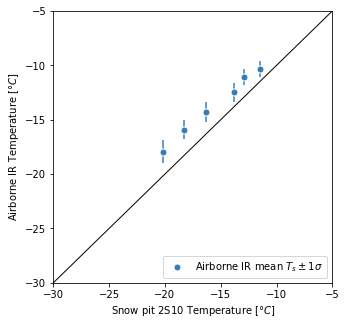

In [17]:
# Select a time window from the timeseries data around each airborne or satellite observation
df = df_merged
gm1 = df_merged
plus_minus_minutes = 10 # e.g. +/- 5 minutes for a 10 minute time window

mean_AirTC_10ft_Avg_C = []
mean_AirTC_20ft_Avg_C = []
mean_IRtarget_nadir1_C_Avg = []
mean_IRtarget_30degN_C_Avg = []
gm1_2s10_IR_45deg_C = []

for i, t in enumerate(times):
    window_start_time = pd.to_datetime(t) - datetime.timedelta(minutes=plus_minus_minutes)
    window_end_time = pd.to_datetime(t) + datetime.timedelta(minutes=plus_minus_minutes)
    df_sliced = df[(df.index>window_start_time) & (df.index<window_end_time)]
    gm1_sliced = gm1[(gm1.index>window_start_time) & (gm1.index<window_end_time)]

    #mean_AirTC_10ft_Avg_C.append(df_sliced.AirTC_10ft_Avg_C.mean())
    mean_AirTC_20ft_Avg_C.append(df_sliced.AirTC_20ft_Avg.mean())
    #mean_IRtarget_nadir1_C_Avg.append(df_sliced.IRtarget_nadir1_C_Avg.mean())
    #mean_IRtarget_30degN_C_Avg.append(df_sliced.IRtarget_30degN_C_Avg.mean())
    gm1_2s10_IR_45deg_C.append(gm1_sliced.rad_avg.mean())
    
if target == 'mesa west':    
   
    fig, ax = plt.subplots(figsize=(6,6))
    
    #ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_peak+273.15,'^g', label='Airborne IR Ttree (mode)')
    #ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_median+273.15,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
    ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_mean+273.15,'og', markerfacecolor='w', label='Airborne IR Ttree (mean)', zorder=999)
        
        
    #ax.errorbar(x=mean_IRtarget_30degN_C_Avg,y=Tsnow_airborneIR_mean+273.15, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')
    ax.errorbar(x=mean_AirTC_20ft_Avg_C,y=Ttree_airborneIR_mean+273.15, yerr=Ttree_airborneIR_std, color='g', linestyle='none', label='+/- 1 $/sigma$')
    
    ax_min, ax_max = -33,-9
    ax.plot([ax_min, ax_max],[ax_min, ax_max],linestyle='-', linewidth=1,color='k')
    
    #ax.axhline(aster_mesa_west_mean_TC,linestyle='-',color='r',label='ASTER IR (mean)')
    #ax.axhline(aster_mesa_west_median_TC,linestyle='--',color='r',label='ASTER IR (median)')
    
    ax.legend()
    
    ax.set_ylim((ax_min, ax_max))
    ax.set_xlim((ax_min, ax_max))
    
    ax.set_xlabel('In Situ Temperatures, $\degree C$\n(IRtarget_30degN_C_Avg & AirTC_20ft_Avg_C)')
    ax.set_ylabel('Airborne IR Temperatures, $\degree C$')
    
    #print('Mean Difference between Airborne Tsnow and IRtarget_30degN_C_Avg:')
    #print(np.mean(Tsnow_airborneIR_mean - mean_IRtarget_30degN_C_Avg))
    print('Mean Difference between Airborne Tveg and mean_AirTC_20ft_Avg_C:')
    print(np.mean(Ttree_airborneIR_mean+273.15 - mean_AirTC_20ft_Avg_C))
    print(Ttree_airborneIR_mean+273.15 - mean_AirTC_20ft_Avg_C)
    
    #########

    
if target == 'snow pit':
    fig, ax = plt.subplots(figsize=(5,5))
    
    #ax.plot(gm1_2s10_IR_45deg_C,Tsnow_airborneIR_peak+273.15,'ob', label='Airborne IR Tsnow (mode)')
    #ax.plot(gm1_2s10_IR_45deg_C,Tsnow_airborneIR_median+273.15,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
    ax.plot((np.array(gm1_2s10_IR_45deg_C)-273.15),Tsnow_airborneIR_mean,'o', markerfacecolor='#377eb8', markeredgecolor='w', markersize=7, label='Airborne IR mean $T_s \pm 1 \sigma$', zorder=999)
        
        
    ax.errorbar(x=(np.array(gm1_2s10_IR_45deg_C)-273.15),y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='#377eb8', linestyle='none', label=None)
    
    ax_min, ax_max = -30,-5
    ax.plot([ax_min, ax_max],[ax_min, ax_max],linestyle='-', linewidth=1,color='k')
    
    #ax.axhline(aster_mesa_west_mean_TC,linestyle='-',color='r',label='ASTER IR (mean)')
    #ax.axhline(aster_mesa_west_median_TC,linestyle='--',color='r',label='ASTER IR (median)')
    
    ax.legend(loc='lower right')
    
    ax.set_ylim((ax_min, ax_max))
    ax.set_xlim((ax_min, ax_max))
    
    ax.set_xlabel('Snow pit 2S10 Temperature [$\degree C$]')
    ax.set_ylabel('Airborne IR Temperature [$\degree C$]')
    
    
    print('Mean Difference between Airborne Tsnow and gm1_2s10_IR_45deg_C:')
    print(np.mean(Tsnow_airborneIR_mean+273.15 - gm1_2s10_IR_45deg_C))
    print(Tsnow_airborneIR_mean+273.15 - gm1_2s10_IR_45deg_C)
    
plt.savefig('fig6d.svg')

---